# Estimate Tokenizer Premium Costs for Low-Resource Langugages

This notebook is designed to provide an estimation of the premium cost associated with tokenizing text for row-resouce languages.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import tiktoken

from llm_lang.assets.flores200_langs import LANGUAGES
from llm_lang.external import flores
from llm_lang.utils import compute_premium
from llm_lang.worldbank import fetch_gdp_per_capita

%load_ext autoreload
%autoreload 2

/Users/g4brielvs/.pyenv/versions/3.10.13/envs/worldbank-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
encodings = tiktoken.list_encoding_names()
encodings.reverse()
encodings

['cl100k_base', 'p50k_edit', 'p50k_base', 'r50k_base', 'gpt2']

### Flores200

Fisrt, we import [Flores200](https://github.com/facebookresearch/flores/blob/main/flores200/README.md) dataset.

In [3]:
fl = flores.Flores200(config_name="eng_Latn")
fl.download_and_prepare()

We calculate the *baseline* premium cost for **English (`eng`)**.

In [4]:
ds = fl.as_dataset(split="devtest")
ENG = fl.as_dataset(split="devtest").to_pandas()
ENG["n_baseline"] = ENG["sentence"].apply(compute_premium)

Subsequently, we calculate the premium cost for all languages relative to **English (`eng`)**.

In [5]:
dfs = []

for lang in LANGUAGES:
    fl = flores.Flores200(config_name=lang)
    fl.download_and_prepare()

    df = fl.as_dataset(split="devtest").to_pandas()
    df["config_name"] = lang
    df["n_tokens"] = df["sentence"].apply(compute_premium)

    df = pd.merge(
        df,
        ENG[
            [
                "id",
                "sentence",
                "n_baseline",
            ]
        ],
        on="id",
    )

    df["cost"] = df["n_tokens"] / df["n_baseline"]

    dfs.append(df)

COSTS = pd.concat(dfs)
COSTS["lang"] = COSTS["config_name"].apply(lambda x: x[:3])

In [6]:
COSTS = COSTS.groupby(["lang"])["cost"].mean().to_frame().reset_index()
COSTS

,lang,cost
0,ace,2.910664
1,acm,3.000731
2,acq,3.031674
3,aeb,2.935153
4,afr,1.705142
...,...,...
191,yor,2.984898
192,yue,2.111599
193,zho,2.019078
194,zsm,1.639492


#### Languages by total number of speakers

In this section, we import the pre-cooked data, whose relevant columns are `language`, `country` and `population_2022adj`, obtaind from [Ethnologue](https://www.ethnologue.com).

```{note}
Please note that the column `population_2022adj either 2022 or 2023, if available or 2022 adjusted.
```

In [24]:
LANG_POP = pd.read_csv("../data/processed/lang_pop2022adj.csv")
LANG_POP[["language", "location", "country", "population_2022adj"]]

,language,location,country,population_2022adj
0,tuk,Afghanistan,AFG,1150000.0
1,kir,Afghanistan,AFG,750.0
2,snd,Afghanistan,AFG,24876.0
3,azj,Afghanistan,AFG,15400.0
4,urd,"Afghanistan, all users. L1 users: 16,900 in Af...",AFG,1247414.0
...,...,...,...,...
3020,por,Zimbabwe,ZWE,18058.0
3021,nya,Zimbabwe,ZWE,506283.0
3022,tsn,Zimbabwe,ZWE,96545.0
3023,sna,"Zimbabwe, all users. L1 users: 7,160,000 in Zi...",ZWE,13325866.0


### Enriching with socioeconomic data

#### World Bank Data 

In this section, we fetch the GDP per capita ([`NY.GDP.PCAP.CD`](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)).

In [8]:
LANG_POP["NY.GDP.PCAP.CD"] = LANG_POP["country"].apply(fetch_gdp_per_capita)

#### World Bank Country API 

The [World Bank Country API](https://datahelpdesk.worldbank.org/knowledgebase/articles/898590-country-api-queries) returns the current (as of 2024) [World Bank Country and Lending Groups](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups).

In [9]:
WB_COUNTRIES = pd.read_csv("../data/processed/language_country_income_level.csv")
WB_COUNTRIES = WB_COUNTRIES.drop_duplicates(["id", "incomeLevel"])
WB_COUNTRIES = WB_COUNTRIES[
    [
        "code",
        "id",
        "name",
        "region",
        "incomeLevel",
        "capitalCity",
        "longitude",
        "latitude",
    ]
]

## Merging and Computing Population-weighted GDP for each Language

In this section, we merge the datasets to obtain information on the *number of speakers* and *GDP per capita* for each `language` and `country`.

In [10]:
df = LANG_POP.merge(
    WB_COUNTRIES, left_on=["country"], right_on=["id"], how="left"
).merge(COSTS, left_on=["language"], right_on=["lang"], how="left")

In [11]:
# df.to_csv("../data/processed/lang_pop2022adj_costs.csv")
# df = pd.read_csv("../data/processed/lang_pop2022adj_costs.csv")

We define an indicator - $W_{lang}$ -  calculated as a population-weighted GDP for the language.

In [12]:
df["wealth"] = df["population_2022adj"] * df["NY.GDP.PCAP.CD"]

wealth = df.groupby(["lang"]).apply(
    lambda x: x["wealth"].sum() / x["population_2022adj"].sum(),
    include_groups=False,
)

And population, 

In [13]:
pop = df.groupby(["lang"])["population_2022adj"].sum()

And income level, 

In [ ]:
df["incomeLevel"] = df["incomeLevel"].map(
    {
        x: i / 5
        for i, x in enumerate(
            [
                "Not classified",
                "Low income",
                "Lower middle income",
                "Upper middle income",
                "High income",
            ]
        )
    }
)

incomeLevel = df.groupby(["lang"])["incomeLevel"].mean().to_frame()

Finally, we compute the indicator by combiting the columns above,

In [15]:
W = (
    pd.merge(
        COSTS,
        wealth.to_frame("wealth").reset_index(),
        left_on="lang",
        right_on="lang",
        how="outer",
    )
    .merge(pop, on="lang")
    .merge(incomeLevel, on="lang")
)

In [16]:
W

,lang,cost,w,population_2022adj,incomeLevel
0,acm,3.000731,7543.131613,18606581.0,0.672000
1,acq,3.031674,2595.585862,12694834.0,0.487500
2,aeb,2.935153,6253.115427,12240945.0,0.745455
3,afr,1.705142,5676.207961,65837380.0,0.586667
4,aka,2.738359,3407.152128,12140954.0,0.577778
...,...,...,...,...,...
167,xho,2.081686,6752.098207,21638367.0,0.500000
168,ydd,5.602995,61969.322679,451255.0,0.714286
169,yor,2.984898,2576.646057,49493154.0,0.511111
170,yue,2.111599,17247.621512,86702360.0,0.664706


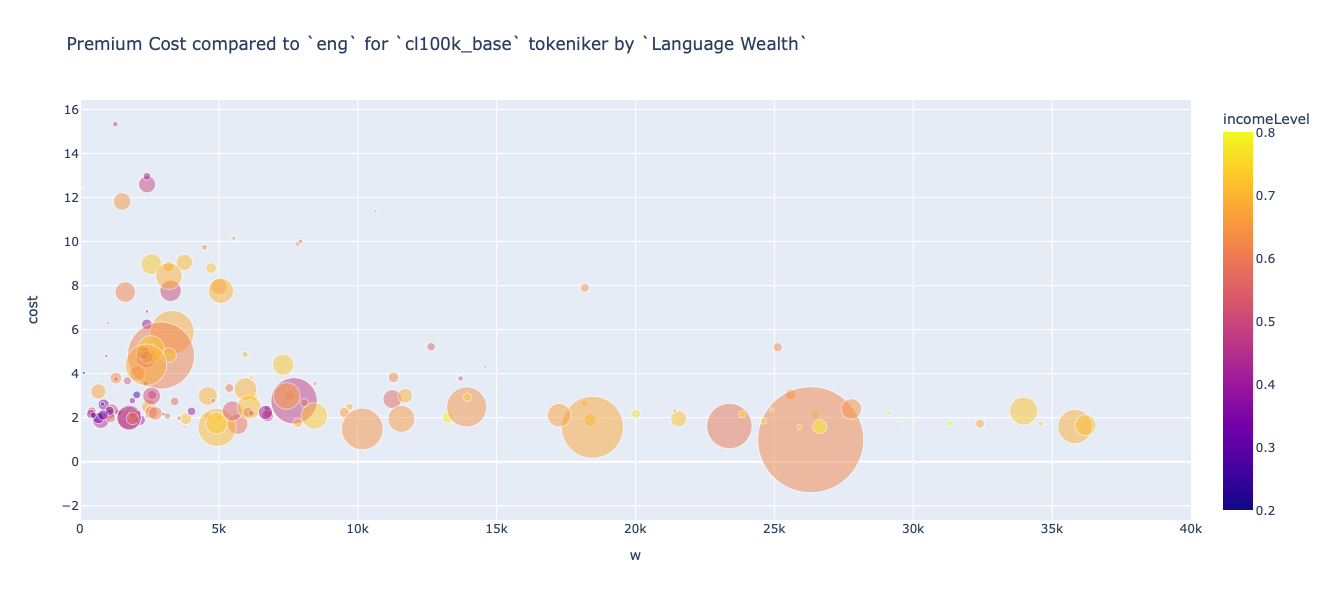

In [23]:
fig = px.scatter(
    W,
    x="w",
    y="cost",
    size="population_2022adj",
    color="incomeLevel",
    hover_name="lang",
    # log_x=True,
    # log_y=False,
    size_max=75,
    range_x=(0, 40_000),
    opacity=0.5,
    title="Premium Cost compared to `eng` for `cl100k_base` tokeniker by `Language Wealth`",
)

fig.update_layout(
    autosize=True,
    width=1200,
    height=600,
)
fig.show()